![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from Jewelry Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

[Complete Journey Dataset](https://www.kaggle.com/frtgnn/dunnhumby-the-complete-journey)

This dataset contains household level transactions over two years from a group of 2,500 households who are frequent shoppers at a retailer. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are included.


## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from pathlib import Path


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [2]:
products_df = pd.read_csv('../data/external/journey/product.csv')
products_df['DESC'] = products_df['COMMODITY_DESC'] + products_df['SUB_COMMODITY_DESC']
print(products_df.head())

transactions = pd.read_csv('../data/external/journey/transaction_data.csv')
print(transactions.head())

   PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  \
0          ICE - CRUSHED/CUBED                22 LB   
1  NO SUBCOMMODITY DESCRIPTION                        
2         BREAD:ITALIAN/FRENCH                        
3                  APPLE SAUCE                50 OZ   
4            SPECIALTY COOKIES                14 OZ   

                                                DESC  
0                        FRZN ICEICE - CRUSHED/CUBED  
1  NO COMMODITY DESCRIPTIONNO SUBCOMMODITY DESCRI...  
2                

# Checking for missing data

In [3]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 2595732


household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

There are 276484 unique transactions

Here are the counts of transactions ordered from largest to smallest
[168 161 155 ...   1   1   1]

And a graph of what the curve looks like:


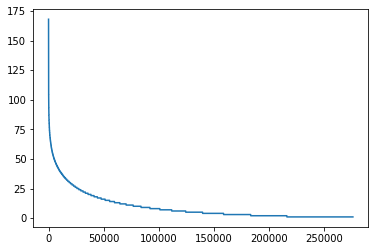

In [4]:
transaction_counts = transactions['BASKET_ID'].value_counts().to_numpy()
print('There are', len(transaction_counts), 'unique transactions\n')
print('Here are the counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# User Interactions

Let's take a look at how many unique customers are included in this dataset

There are 2500 unique customers

Here are the counts of transactions per customer ordered from largest to smallest
[6851 6646 6625 ...    7    5    4]

And a graph of what the curve looks like:


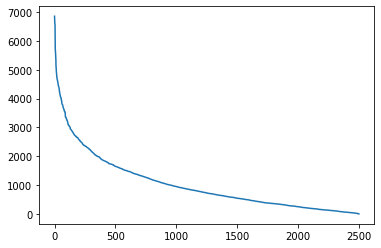

In [5]:
user_counts = transactions['household_key'].value_counts().to_numpy()
print('There are', len(user_counts), 'unique customers\n')
print('Here are the counts of transactions per customer ordered from largest to smallest')
print(user_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(user_counts) 
plt.show()

In [6]:
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.0f}'.format


transactions.groupby(['household_key'])['household_key'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,household_key,count
717,718,6851
2458,2459,6646
1608,1609,6625
1110,1111,6576
1452,1453,6561
981,982,5806
2321,2322,5692
370,371,5669
1488,1489,5586
2336,2337,5517


In [7]:
transactions[transactions.household_key == 718].groupby(transactions.BASKET_ID).count()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
BASKET_ID,,,,,,,,,,,,
26985360571,85,85,85,85,85,85,85,85,85,85,85,85
26997328096,21,21,21,21,21,21,21,21,21,21,21,21
27021567259,11,11,11,11,11,11,11,11,11,11,11,11
27021568504,20,20,20,20,20,20,20,20,20,20,20,20
27069811749,26,26,26,26,26,26,26,26,26,26,26,26
...,...,...,...,...,...,...,...,...,...,...,...,...
42090812149,15,15,15,15,15,15,15,15,15,15,15,15
42097841965,22,22,22,22,22,22,22,22,22,22,22,22
42198898054,120,120,120,120,120,120,120,120,120,120,120,120


It appears that there are a lot of different transactions, so probably not just the same thing being purchased over and over. Not really sure what to do with this at the moment.

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

<AxesSubplot:xlabel='DAY'>

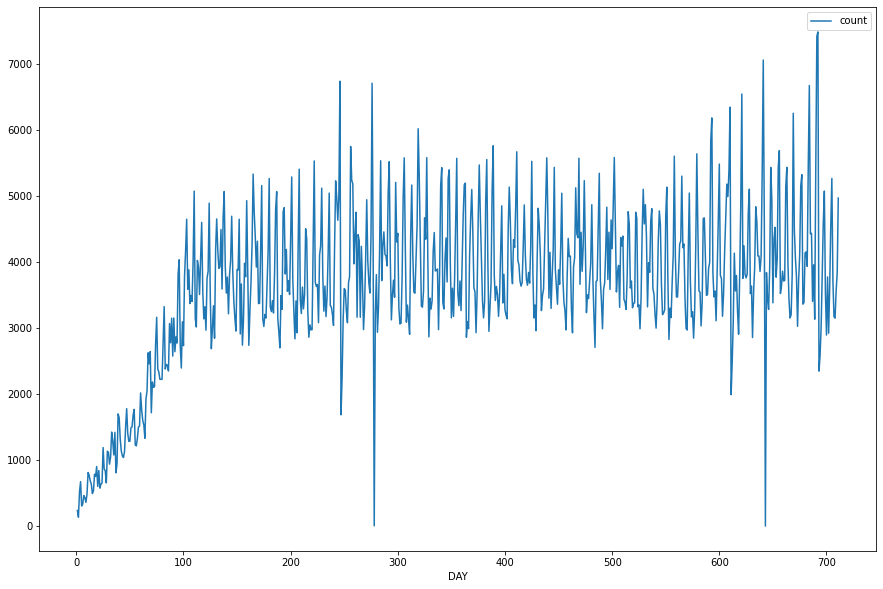

In [8]:
transactions.groupby(['DAY'])['DAY'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['DAY'], ascending=True) \
                             .plot(x='DAY', y='count', figsize=(15,10))

# Checking Invoice Totals

We need to make sure all the invoice totals that we're using are positive - this keeps us from using invoices that captured customer returned items.

<AxesSubplot:xlabel='BASKET_ID'>

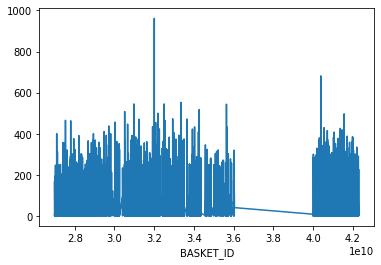

In [9]:
totals = transactions.groupby(transactions.BASKET_ID)['SALES_VALUE'].sum()
totals.plot()

In [10]:
totals.sort_values(ascending=False)

BASKET_ID
32006114302   961
40387571385   682
33347880492   553
32505140858   545
30983766334   545
               ..
40025748519     0
32932195911     0
30627631790     0
41225185620     0
31184741340     0
Name: SALES_VALUE, Length: 276484, dtype: float64

In [11]:
print('There are', len(transactions[transactions.QUANTITY < 0]), 'negative quantities')
transactions[transactions.QUANTITY < 0].head()

There are 0 negative quantities


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC


It looks like the negative quantities are driven by returned items. Let's see if anyone purchased and returned items in the same transaction:

In [12]:
temp_df = transactions.groupby(transactions.BASKET_ID).agg(minQ=('QUANTITY', 'min'), 
                               maxQ=('QUANTITY', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
BASKET_ID,,


In [13]:
print('There are', len(transactions[transactions.SALES_VALUE < 0]), 'negative prices')
transactions[transactions.SALES_VALUE < 0].head()

There are 0 negative prices


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC


We can also check these transactions to see if there was a mix of negative prices along with positive.

In [14]:
temp_df = transactions.groupby(transactions.BASKET_ID).agg(minQ=('SALES_VALUE', 'min'), 
                               maxQ=('SALES_VALUE', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
BASKET_ID,,


Now that we have identified the cause of negative totals, we can remove them so that they do not affect our model.

In [15]:
transactions = transactions[(transactions.QUANTITY > 0) & (transactions.SALES_VALUE > 0)]

Now we can check the totals that were much higher than average

In [16]:
transactions[transactions.BASKET_ID == 32006114302].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
1085406,1609,32006114302,339,825731,1,2,412,-0,2038,49,0,0
1085407,1609,32006114302,339,838971,1,5,412,-0,2038,49,0,0
1085408,1609,32006114302,339,853354,1,2,412,0,2038,49,0,0
1085409,1609,32006114302,339,862725,2,5,412,0,2038,49,0,0
1085410,1609,32006114302,339,866211,1,4,412,0,2038,49,0,0


In [17]:
len(transactions[transactions.BASKET_ID == 32006114302])

38

It looks like there are two distinct cases where we may have an issue:

1. Extremely high priced items
2. Extremely high numbers of items purchased on the same transaction

We can remove both of these by just keeping the values within the 98% quantile

In [18]:
q = transactions["SALES_VALUE"].quantile(0.98)
print(q)
#transactions = transactions[transactions["price"] < q]

13.37


In [19]:
q = transactions["QUANTITY"].quantile(0.98)
print(q)
# transactions = transactions[transactions["quantity"] < q]

5.0


# Products Purchased Once

Let's find products that were only purchased once and filter them out of the dataset.

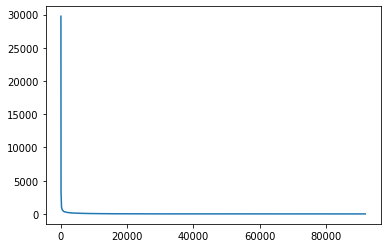

Products with at least 2 purchase: 58383
Products with less than 2 purchase: 33522
Original dataframe length: 2576815
Filtered dataframe length: 2543293


In [20]:
product_counts = transactions.groupby(transactions.PRODUCT_ID)['PRODUCT_ID'].count().sort_values(ascending=False).to_numpy()

plt.plot(product_counts)
plt.show()

minimum_purchaces = 2
product_group = transactions.loc[:, ['BASKET_ID', 'PRODUCT_ID']].groupby('PRODUCT_ID').count()
 
multi_purchase = product_group[(product_group.BASKET_ID >= minimum_purchaces)].count()
single_purchase = product_group[(product_group.BASKET_ID < minimum_purchaces)].count()
 
print('Products with at least',minimum_purchaces,'purchase:',multi_purchase['BASKET_ID'])
print('Products with less than',minimum_purchaces,'purchase:',single_purchase['BASKET_ID'])
 
# We can capture the list of mutiple product orders with this:
product_filter = product_group[(product_group.BASKET_ID >= minimum_purchaces)].index.tolist()

filtered_df = transactions[transactions['PRODUCT_ID'].isin(product_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

# Orders with a single item

We will need to remove transactions that only included a single item

In [21]:
minimum_order_size = 2
order_group = filtered_df.loc[:, ['BASKET_ID', 'PRODUCT_ID']].groupby('BASKET_ID').count()
 
multi_order = order_group[(order_group.PRODUCT_ID >= minimum_order_size)].count()
single_order = order_group[(order_group.PRODUCT_ID < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['PRODUCT_ID'])
print('Orders with less than',minimum_order_size,'products:',single_order['PRODUCT_ID'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.PRODUCT_ID >= minimum_order_size)].index.tolist()

Orders with at least 2 products: 213770
Orders with less than 2 products: 60631


In [22]:
filtered_df = filtered_df[filtered_df['BASKET_ID'].isin(order_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 2576815
Filtered dataframe length: 2482662


# Returning Customers

We may also want to remove single visit customers. This is something to try and see if it reduces the sparcity. We may also want to remove users that make a much larger number of purchases than the average.

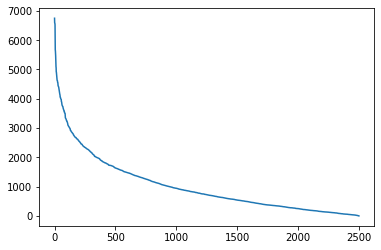

Users with at least 2 purchase: 2500
Users with less than 2 purchase: 0


In [23]:
user_counts = transactions.groupby(transactions.household_key)['household_key'].count().sort_values(ascending=False).to_numpy()

plt.plot(user_counts)
plt.show()

minimum_purchaces = 2
user_group = transactions.loc[:, ['BASKET_ID', 'household_key']].groupby('household_key').count()
 
multi_purchase = user_group[(user_group.BASKET_ID >= minimum_purchaces)].count()
single_purchase = user_group[(user_group.BASKET_ID < minimum_purchaces)].count()
 
print('Users with at least',minimum_order_size,'purchase:',multi_purchase['BASKET_ID'])
print('Users with less than',minimum_order_size,'purchase:',single_purchase['BASKET_ID'])
 
# We can capture the list of mutiple product orders with this:
user_filter = user_group[(user_group.BASKET_ID >= minimum_order_size)].index.tolist()

In [24]:
filtered_df = filtered_df[filtered_df['household_key'].isin(user_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 2576815
Filtered dataframe length: 2482662


# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [25]:
transaction_list = list(np.sort(filtered_df.BASKET_ID.unique())) # Get our unique customers
item_list = list(filtered_df.PRODUCT_ID.unique()) # Get our unique products that were purchased
quantity_list = list(filtered_df.QUANTITY) # All of our purchases

cols = filtered_df.BASKET_ID.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = filtered_df.PRODUCT_ID.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [26]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.98008043099004

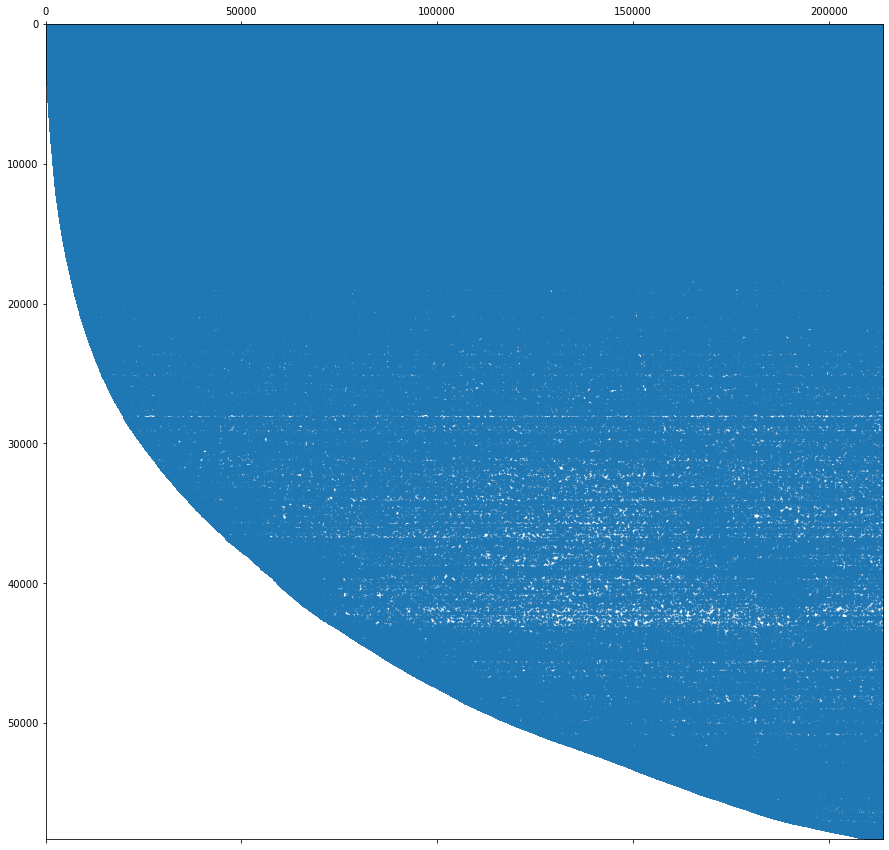

In [27]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

In [28]:
joined = filtered_df.join(products_df, on='PRODUCT_ID', rsuffix='_p')
joined = joined.rename(columns={"PRODUCT_ID": "product_id", "QUANTITY": "quantity", "BASKET_ID": "order_id", "DESC": "description", "SALES_VALUE": "price"})
final_df = joined[["order_id", "product_id", "quantity", "price", "description"]]

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [29]:
Path("../data/interim/journey").mkdir(parents=True, exist_ok=True)
final_df.to_pickle(path='../data/interim/journey/transactions.gz')